# look at HEK293T editing rates -- multi loci

### Import packages

In [1]:
import sys,os, glob
import shutil

import matplotlib as plt
plt.rcParams['pdf.fonttype'] = 42

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

from Bio import SeqIO
import fuzzysearch
import re
from collections import Counter, OrderedDict
from Bio.Seq import Seq

In [2]:
run = "./miseq/msSBK_22-292920645/FASTQ_Generation_2021-09-10_16_52_56Z-458786333"
os.chdir(run)

### load dataframe of sample ID and conditions 

In [3]:
samples = pd.read_excel("samples.xlsx")[["sample_name", "description", "Sub-Library Owner"]]
samples

,sample_name,description,Sub-Library Owner
0,msSBK_22_01,10/90 D0 rep 1,KDC
1,msSBK_22_02,50/50 D0 rep 1,KDC
2,msSBK_22_03,90/10 D0 rep 1,KDC
3,msSBK_22_04,10/90 D4 + rep 1,KDC
4,msSBK_22_05,10/90 D4 - rep 1,KDC
...,...,...,...
194,NaN,NaN,Sequence:
195,NaN,NaN,AATGATACGGCGACCACCGAGATCTACACTAGATCGCTCGTCGGCA...
196,NaN,NaN,AATGATACGGCGACCACCGAGATCTACACCTCTCTATTCGTCGGCA...
197,NaN,NaN,CAAGCAGAAGACGGCATACGAGATTCGCCTTAGTCTCGTGGGCTCG...


In [6]:
print ("="*60)
for file in glob.glob("msSBK_*_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    owner = samples["Sub-Library Owner"][samples["sample_name"]==fn].to_string(index=False)
   
    if "SCL" in owner:
        print (owner)
       
        print (fn + " -- " + condition)
        os.chdir(file)
        r1 = glob.glob("*R1_001*")[0]
        print (r1)
        
        print ("\ntrimming files\n")
        cmd = "sickle se -f {0} -t sanger \
                -o trimmed_R1.fastq".format(r1)
        os.system(cmd)    
        print ("="*60)

        os.chdir(run)
        
    else:
        
        shutil.rmtree(file, ignore_errors=True)
os.chdir(run)

 SCL
msSBK_22_88 --  BL21AI +146 +O/N R1
msSBK-22-88_S88_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_22_57 --  HEK293T +139 +176 day3 R3
msSBK-22-57_S57_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_22_68 --  HEK293T +139 +178 day3 R2
msSBK-22-68_S68_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_22_87 --  BL21AI +162 +O/N R3
msSBK-22-87_S87_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_22_80 --  HEK293T +139 +180 day3 R2
msSBK-22-80_S80_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_22_109 --  BL21AI +165 +O/N R1
msSBK-22-109_S109_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_22_116 --  BL21AI +169 +O/N R2
msSBK-22-116_S116_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_22_60 --  HEK293T +140 +176 day3 R3
msSBK-22-60_S60_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_22_102 --  BL21AI +pSKL58 +O/N R3
msSBK-22-102_S102_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_22_78 --  HEK293T +140 +179 day3 R3
msSBK-22-78_S78_L001_R1_001.fastq.gz



In [19]:
## regions to look for: flanking left right = 30bp; wt edited: 20bp with edit in middle
Region_dict = {'AAVS1': {'outside flanking': ['CTGGGACCACCTTATATTCCCAGGGCCGGT','GATATTCGTCTAACCCCCACCTCCTGTTAG'], 
                         "inside flanking": ["GGTTCTGGGTACTTTTATCTGTCCCCTCCA", "GGACAGGATTGGTGACAGAAAAGCCCCCAT"], 
                         'wt_or_edited': ['CCCCACAGTGGGGCCACTAG','CCCCACAATGGAACCACTAG']
                        },
               "HEK3": {'outside flanking': ['TGCATTTGTAGGCTTGATGCTTTTTTTCTG','AGTATGTGCAGCTCCTGCACCGGGATACTG'], 
                         "inside flanking": ["GGCCTGGGTCAATCCTTGGGGCCCAGACTG", "AGGAAGCCCTGCTTCCTCCAGAGGGCGTCG"], 
                         'wt_or_edited': ['AGCACGTGATGGCAGAGGAA','AGCACGTGCTAACAGAGGAA']
                        },
               "RNF2": {'outside flanking': ['CTTTATTTCCAGCAATGTCTCAGGCTGTGC','ATACATTTTTAGAACATGAAAACTTAAATA'], 
                         "inside flanking": ["ACATGGGAACTCAGTTTATATGAGTTACAA", "TAAGATGACTGCCAAGGGGCATATGAGACG"], 
                         'wt_or_edited': ['CGAACACCTCAGGTAATGAC','CGAACATTTCATGTAATGAC']
                        },
               "EMX1": {'outside flanking': ['AGGTGTGGTTCCAGAACCGGAGGACAAAGT','CCTCCAATGACTAGGGTGGGCAACCACAAA'], 
                         "inside flanking": ["AGCTGGAGGAGGAAGGGCCTGAGTCCGAGC", "CACATCAACCGGTGGCGCATTGCCACGAAG"], 
                         'wt_or_edited': ['AGAAGAAGAAGGGCTCCCAT','AGAAGAAAAAGTTCTCCCAT']
                        },
               "FANCF": {'outside flanking': ['CAGTACGCAGAGAGTCGCCGTCTCCAAGGT','GTGCGCCGGGCCTTGCAGTGGGCGCGCTAC'], 
                         "inside flanking": ["AGGGCCTTCGCGCACCTCATGGAATCCCTT", "TTCCGAGCTTCTGGCGGTCTCAAGCACTAC"], 
                         'wt_or_edited': ['CTGCAGCACCTGGATCGCTT','CTGCAGCATCTAGATCGCTT']
                        },
               "HEK4": {'outside flanking': ['AGGAAGGGCGAGGCAGAGGGTCCAAAGCAG','CCAGGCCTGTGTGTGTGTCTCCGTTCGGGT'], 
                         "inside flanking": ["GGCACCGCGGCGCCCCGGTGGCACTGCGGC", "GAGACTCTGGTGCTGTGTGACTACAGTGGG"], 
                         'wt_or_edited': ['TGGAGGTGGGGGTTAAAGCG','TGGAGGCGGGAATTAAAGCG']
                        }
              }

def extract_and_exact_match(sequence):
        inner_left_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['inside flanking'][0],sequence,max_l_dist=4)
        inner_right_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['inside flanking'][1],sequence,max_l_dist=4)
        if len(inner_left_flank) == 1 and len(inner_right_flank) == 1:
            region = sequence[inner_left_flank[0].end:inner_right_flank[0].start]
            if region == Region_dict[edit_site]['wt_or_edited'][0]:
                return ('wt', region)
            if region == Region_dict[edit_site]['wt_or_edited'][1]:
                return ('edited', region)
            else: 
                return ('undetermined_no_site_match', region)
        else:
            return ('undetermined_no_flanking_match', None)


In [21]:
os.chdir(run)

df_exact_files = pd.DataFrame(columns=["sample_name", "condition", "wt", "edited",
                                 "undetermined_no_flanking_match", 'undetermined_no_site_match',
                                 "total reads", "edited_percent"])
fastq_reads = "trimmed_R1.fastq"
print ("="*60)

non_precise_exact = []
sequencing_artifact = []



for file in glob.glob("msSBK_*_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    if "HEK" in condition:
        if "175" in condition:
            edit_site = "HEK3"
        elif "176" in condition:
            edit_site = "RNF2"
        elif "177" in condition:
            edit_site = "EMX1"
        elif "178" in condition:
            edit_site = "FANCF"
        elif "179" in condition:
            edit_site = "HEK4"
        elif "180" in condition:
            edit_site = "AAVS1"

        all_reads_str = []
        outcomes_dict = {'wt':0,
                     'edited':0,
                     'undetermined_no_flanking_match':0,
                     'undetermined_no_site_match':0,
                    "sequencing artifact": 0,
                    "wt + indels": 0,
                    "edit + indels": 0}

        print (fn + " -- " + condition)
        os.chdir(file)

        filename = glob.glob("*.fastq.gz")

        for seq_record in SeqIO.parse(fastq_reads, "fastq"):
            all_reads_str.append(str(seq_record.seq))
        read_counter = Counter(all_reads_str)
        for read in read_counter:
            if ((extract_and_exact_match(read)[0]=='undetermined_no_site_match')
                or 
                (extract_and_exact_match(read)[0]=='wt + indels')
                or 
                (extract_and_exact_match(read)[0]=='edit + indels')):
                non_precise_exact.append(extract_and_exact_match(read)[1])
            if extract_and_exact_match(read)[0]=='sequencing artifact':
                sequencing_artifact.append(extract_and_exact_match(read)[1])
            outcomes_dict[extract_and_exact_match(read)[0]] += read_counter[read]
        try:
            edited_percent = (float(outcomes_dict['edited'])/float(outcomes_dict['edited']+
                                                                   outcomes_dict['wt']+
                                                                   outcomes_dict["undetermined_no_site_match"]+ 
                                                                   outcomes_dict["wt + indels"]+ 
                                                                   outcomes_dict["edit + indels"]
                                                                ))*100
        except:
            edited_percent = 0


        print ('{0} percent edited ({1} edited/ {2} wt+indels+edited)'.format(edited_percent,outcomes_dict['edited'],outcomes_dict['wt']+outcomes_dict['edited']+outcomes_dict['undetermined_no_site_match']))
        print ('{0} do not contain clean flanking regions'.format(outcomes_dict['undetermined_no_flanking_match']))
        print ('{0} contain flanking regions, but not a clean target site match to edited or wt'.format(outcomes_dict['undetermined_no_site_match']))
        print (" {0} don't contain the outside flanking regions, and are perhaps sequencing artifacts".format(outcomes_dict["sequencing artifact"]))

        if (outcomes_dict['wt'] + outcomes_dict["edited"] + outcomes_dict['undetermined_no_flanking_match'] + outcomes_dict['undetermined_no_site_match'])>0:
            df_exact_files = df_exact_files.append({"sample_name": fn, "condition": condition, 
                                         "wt": outcomes_dict['wt'], "edited": outcomes_dict['edited'],
                                        'wt + indels': outcomes_dict['wt + indels'],
                                        'edit + indels':    outcomes_dict['edit + indels'],
                                         "undetermined_no_flanking_match": outcomes_dict['undetermined_no_flanking_match'],
                                         'undetermined_no_site_match': outcomes_dict['undetermined_no_site_match'],
                                         "total reads": outcomes_dict['wt'] + outcomes_dict["edited"] + outcomes_dict['undetermined_no_flanking_match'] + outcomes_dict['undetermined_no_site_match'],
                                         "edited_percent": edited_percent, 
                                         "non_precise_edits_percent": 
                                                    ((outcomes_dict['undetermined_no_site_match'] +
                                                      outcomes_dict["wt + indels"]+
                                                     outcomes_dict["edit + indels"])/(outcomes_dict['wt'] + 
                                                     outcomes_dict["edited"] + 
                                                     outcomes_dict["wt + indels"] + 
                                                     outcomes_dict["edit + indels"] + 
                                                     #outcomes_dict['undetermined_no_flanking_match'] + 
                                                     outcomes_dict['undetermined_no_site_match']))*100},
                                        ignore_index=True,)
            print ((outcomes_dict['undetermined_no_site_match'] +
                  outcomes_dict["wt + indels"]+
                 outcomes_dict["edit + indels"])/(outcomes_dict['wt'] + 
                 outcomes_dict["edited"] + 
                 outcomes_dict["wt + indels"] + 
                 outcomes_dict["edit + indels"] + 
                 outcomes_dict['undetermined_no_flanking_match'] + 
                 outcomes_dict['undetermined_no_site_match'])*100, "indel percent")
            print ("parsing done.\n"+ "="*60 + "\n")

        else:
            pass
    os.chdir(run)

msSBK_22_57 --  HEK293T +139 +176 day3 R3
0.1765999251497006 percent edited (151 edited/ 85504 wt+indels+edited)
2645 do not contain clean flanking regions
5052 contain flanking regions, but not a clean target site match to edited or wt
 0 don't contain the outside flanking regions, and are perhaps sequencing artifacts
5.731205118605997 indel percent
parsing done.

msSBK_22_68 --  HEK293T +139 +178 day3 R2
1.096319498825372 percent edited (350 edited/ 31925 wt+indels+edited)
64795 do not contain clean flanking regions
2471 contain flanking regions, but not a clean target site match to edited or wt
 0 don't contain the outside flanking regions, and are perhaps sequencing artifacts
2.55479735318445 indel percent
parsing done.

msSBK_22_80 --  HEK293T +139 +180 day3 R2
0.8063512605460291 percent edited (324 edited/ 40181 wt+indels+edited)
3563 do not contain clean flanking regions
6123 contain flanking regions, but not a clean target site match to edited or wt
 0 don't contain the outside

In [23]:
df_exact_files = df_exact_files.sort_values("edited_percent")
df_exact_files

,sample_name,condition,wt,edited,undetermined_no_flanking_match,undetermined_no_site_match,total reads,edited_percent,edit + indels,non_precise_edits_percent,wt + indels
33,msSBK_22_76,HEK293T +140 +179 day3 R1,44337,0,31931,8584,84852,0.000000,0.0,16.220404,0.0
4,msSBK_22_78,HEK293T +140 +179 day3 R3,32667,0,72855,6919,112441,0.000000,0.0,17.478401,0.0
7,msSBK_22_77,HEK293T +140 +179 day3 R2,46003,0,124199,8399,178601,0.000000,0.0,15.438771,0.0
22,msSBK_22_82,HEK293T +140 +180 day3 R1,41696,0,4002,8942,54640,0.000000,0.0,17.658675,0.0
16,msSBK_22_83,HEK293T +140 +180 day3 R2,68236,8,6930,14946,90120,0.009617,0.0,17.966102,0.0
3,msSBK_22_60,HEK293T +140 +176 day3 R3,192866,37,4281,12584,209768,0.018006,0.0,6.123988,0.0
24,msSBK_22_58,HEK293T +140 +176 day3 R1,115172,44,9957,8910,134083,0.035448,0.0,7.178190,0.0
14,msSBK_22_59,HEK293T +140 +176 day3 R2,169966,92,11892,13658,195608,0.050077,0.0,7.434301,0.0
35,msSBK_22_84,HEK293T +140 +180 day3 R3,2729,3,369,584,3685,0.090470,0.0,17.611580,0.0
12,msSBK_22_56,HEK293T +139 +176 day3 R2,84298,90,4100,5142,93630,0.100525,0.0,5.743326,0.0


In [36]:
df_exact_plot = df_exact_files.copy()

print (df_exact_plot["condition"].str.split(" ", n=6, expand = True))

df_exact_plot[["placehold", "cells", "protein", "ncRNA", "day", "rep"]] = df_exact_plot["condition"].str.split(" ", n=6, expand = True)
df_exact_plot = df_exact_plot.drop(["placehold"], axis=1)
df_exact_plot = df_exact_plot.sort_values("edited_percent")

d = {"+139": "Cas9-P2A-Eco1RT",
     "+140": "Cas9",
        }

ncrna = {"+175": "HEK3 editing ncRNA-gRNA",
        "+176": "RNF2 editing ncRNA-gRNA",
        "+177": "EMX1 editing ncRNA-gRNA",
        "+178": "FANCF editing ncRNA-gRNA",
        "+179": "HEK4 editing ncRNA-gRNA", 
        "+180": "AAVS1 editing ncRNA-gRNA"
        }

site = {"+175": "HEK3",
        "+176": "RNF2",
        "+177": "EMX1",
        "+178": "FANCF",
        "+179": "HEK4", 
        "+180": "AAVS1"
        }

day = {"day1": "1",
     "day3": "3",
        }

df_exact_plot["genotype"] = df_exact_plot["protein"].map(d)
df_exact_plot["ncRNA"] = df_exact_plot["ncRNA"].map(ncrna)
df_exact_plot["day"] = df_exact_plot["day"].map(day)
df_exact_plot["site"] = df_exact_plot["ncRNA"].str.split(" ", 3).str[0]

df_exact_plot["proteins_ncRNA"] = df_exact_plot["genotype"]+ " + " + df_exact_plot["ncRNA"]

display(df_exact_plot)

   0        1     2     3     4   5
33    HEK293T  +140  +179  day3  R1
4     HEK293T  +140  +179  day3  R3
7     HEK293T  +140  +179  day3  R2
22    HEK293T  +140  +180  day3  R1
16    HEK293T  +140  +180  day3  R2
3     HEK293T  +140  +176  day3  R3
24    HEK293T  +140  +176  day3  R1
14    HEK293T  +140  +176  day3  R2
35    HEK293T  +140  +180  day3  R3
12    HEK293T  +139  +176  day3  R2
28    HEK293T  +139  +176  day3  R1
19    HEK293T  +140  +175  day3  R2
25    HEK293T  +140  +175  day3  R3
29    HEK293T  +140  +178  day3  R2
0     HEK293T  +139  +176  day3  R3
5     HEK293T  +140  +178  day3  R1
13    HEK293T  +140  +178  day3  R3
23    HEK293T  +140  +175  day3  R1
27    HEK293T  +140  +177  day3  R2
34    HEK293T  +140  +177  day3  R3
10    HEK293T  +139  +179  day3  R1
11    HEK293T  +140  +177  day3  R1
9     HEK293T  +139  +175  day3  R1
18    HEK293T  +139  +175  day3  R2
21    HEK293T  +139  +175  day3  R3
2     HEK293T  +139  +180  day3  R2
30    HEK293T  +139  +180  d

,sample_name,condition,wt,edited,undetermined_no_flanking_match,undetermined_no_site_match,total reads,edited_percent,edit + indels,non_precise_edits_percent,wt + indels,cells,protein,ncRNA,day,rep,genotype,site,proteins_ncRNA
33,msSBK_22_76,HEK293T +140 +179 day3 R1,44337,0,31931,8584,84852,0.000000,0.0,16.220404,0.0,HEK293T,+140,HEK4 editing ncRNA-gRNA,3,R1,Cas9,HEK4,Cas9 + HEK4 editing ncRNA-gRNA
4,msSBK_22_78,HEK293T +140 +179 day3 R3,32667,0,72855,6919,112441,0.000000,0.0,17.478401,0.0,HEK293T,+140,HEK4 editing ncRNA-gRNA,3,R3,Cas9,HEK4,Cas9 + HEK4 editing ncRNA-gRNA
7,msSBK_22_77,HEK293T +140 +179 day3 R2,46003,0,124199,8399,178601,0.000000,0.0,15.438771,0.0,HEK293T,+140,HEK4 editing ncRNA-gRNA,3,R2,Cas9,HEK4,Cas9 + HEK4 editing ncRNA-gRNA
22,msSBK_22_82,HEK293T +140 +180 day3 R1,41696,0,4002,8942,54640,0.000000,0.0,17.658675,0.0,HEK293T,+140,AAVS1 editing ncRNA-gRNA,3,R1,Cas9,AAVS1,Cas9 + AAVS1 editing ncRNA-gRNA
16,msSBK_22_83,HEK293T +140 +180 day3 R2,68236,8,6930,14946,90120,0.009617,0.0,17.966102,0.0,HEK293T,+140,AAVS1 editing ncRNA-gRNA,3,R2,Cas9,AAVS1,Cas9 + AAVS1 editing ncRNA-gRNA
3,msSBK_22_60,HEK293T +140 +176 day3 R3,192866,37,4281,12584,209768,0.018006,0.0,6.123988,0.0,HEK293T,+140,RNF2 editing ncRNA-gRNA,3,R3,Cas9,RNF2,Cas9 + RNF2 editing ncRNA-gRNA
24,msSBK_22_58,HEK293T +140 +176 day3 R1,115172,44,9957,8910,134083,0.035448,0.0,7.178190,0.0,HEK293T,+140,RNF2 editing ncRNA-gRNA,3,R1,Cas9,RNF2,Cas9 + RNF2 editing ncRNA-gRNA
14,msSBK_22_59,HEK293T +140 +176 day3 R2,169966,92,11892,13658,195608,0.050077,0.0,7.434301,0.0,HEK293T,+140,RNF2 editing ncRNA-gRNA,3,R2,Cas9,RNF2,Cas9 + RNF2 editing ncRNA-gRNA
35,msSBK_22_84,HEK293T +140 +180 day3 R3,2729,3,369,584,3685,0.090470,0.0,17.611580,0.0,HEK293T,+140,AAVS1 editing ncRNA-gRNA,3,R3,Cas9,AAVS1,Cas9 + AAVS1 editing ncRNA-gRNA
12,msSBK_22_56,HEK293T +139 +176 day3 R2,84298,90,4100,5142,93630,0.100525,0.0,5.743326,0.0,HEK293T,+139,RNF2 editing ncRNA-gRNA,3,R2,Cas9-P2A-Eco1RT,RNF2,Cas9-P2A-Eco1RT + RNF2 editing ncRNA-gRNA


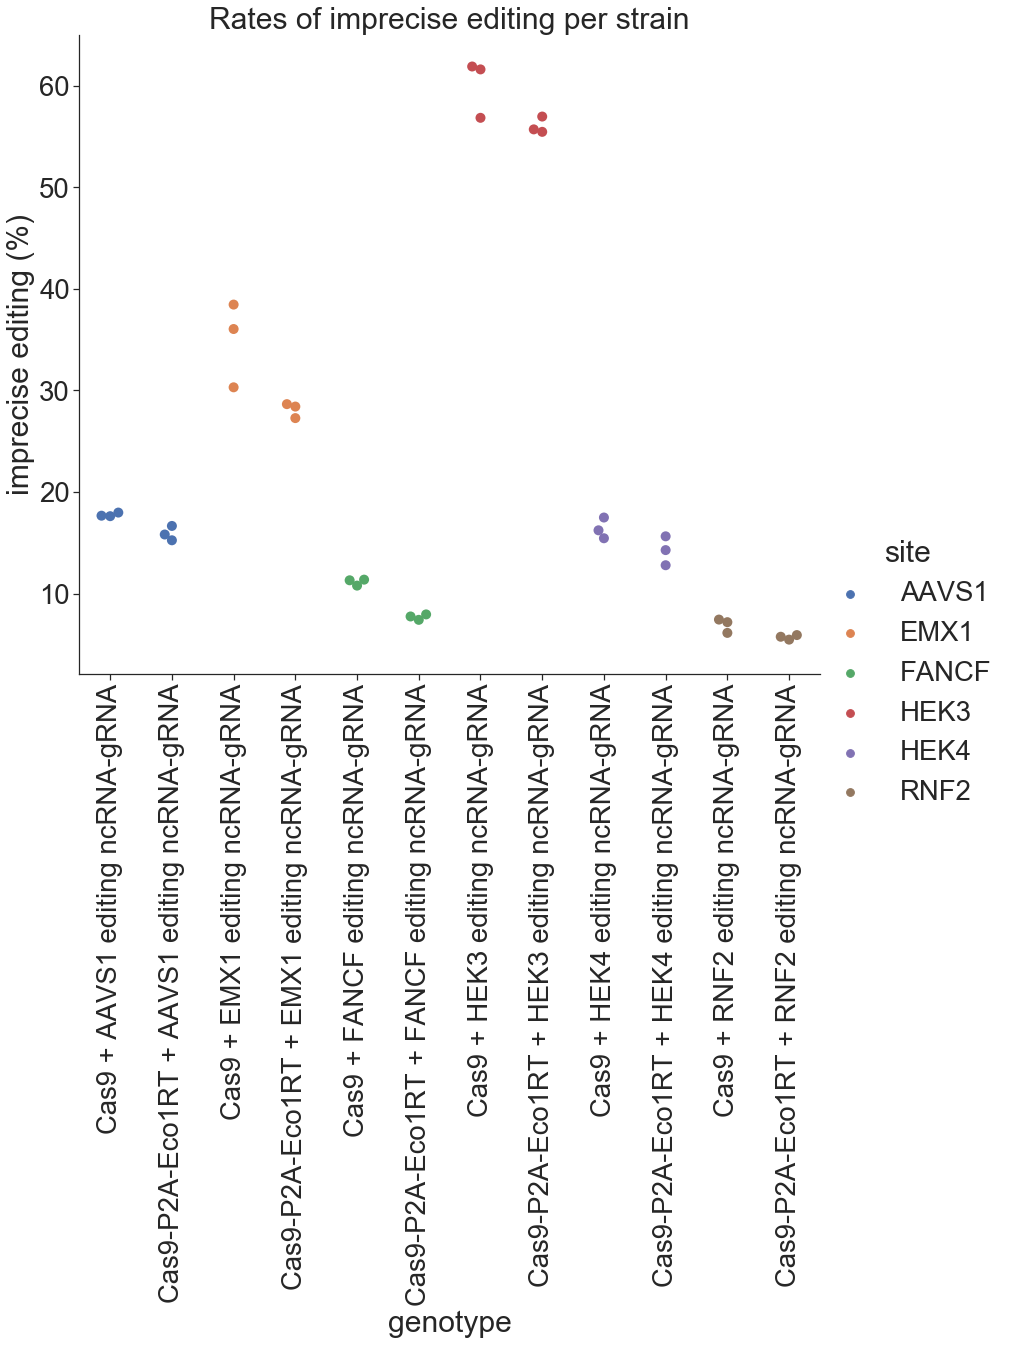

In [7]:
df_exact_plot = df_exact_plot.sort_values(["site", "genotype"])


sns.set(font_scale = 2.5)
sns.set_style("ticks")


g = sns.catplot(x="proteins_ncRNA", y="non_precise_edits_percent",  hue = "site", #hue_order = ["+139", "+140"], # hue="genotype",
        data=df_exact_plot, kind="swarm", height=10.27, aspect=8.7/6.27, s=10)


g.set(xlabel='genotype', ylabel='imprecise editing (%)', title="Rates of imprecise editing per strain")
g.set_xticklabels(rotation=90)

g.savefig("hek293t_imprecise_editing_percent.pdf")


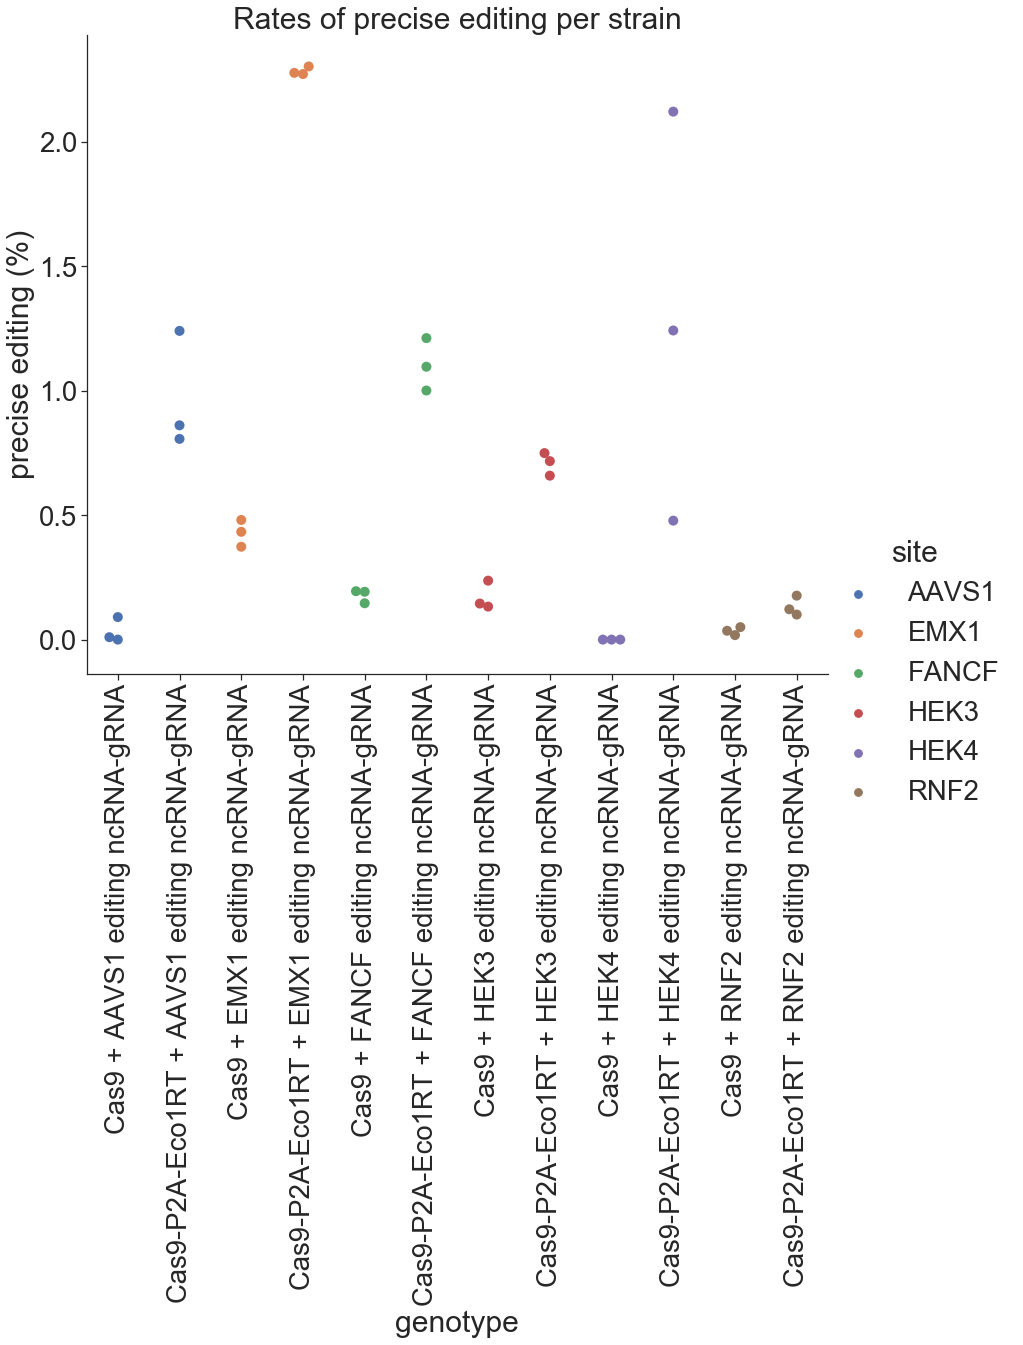

In [8]:
df_exact_plot = df_exact_plot.sort_values(["site", "genotype"])

sns.set(font_scale = 2.5)
sns.set_style("ticks")


g = sns.catplot(x="proteins_ncRNA", y="edited_percent",  hue = "site", #hue_order = ["+139", "+140"], # hue="genotype",
        data=df_exact_plot, kind="swarm", height=10.27, aspect=8.7/6.27, s=10)


g.set(xlabel='genotype', ylabel='precise editing (%)', title="Rates of precise editing per strain")
g.set_xticklabels(rotation=90)

g.savefig("hek293t_precise_editing_percent.pdf")


In [ ]:
df_exact_plot.to_csv("HEK editing 10102021.csv", sep = "\t")